In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/olist_order_payments_dataset.csv
./data/olist_sellers_dataset.csv
./data/olist_order_reviews_dataset.csv
./data/olist_order_items_dataset.csv
./data/olist_orders_dataset.csv
./data/olist_geolocation_dataset.csv
./data/olist_products_dataset.csv
./data/olist_customers_dataset.csv
./data/product_category_name_translation.csv


In [2]:
customers = pd.read_csv("./data/olist_customers_dataset.csv")
sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")
items = pd.read_csv("./data/olist_order_items_dataset.csv")
products = pd.read_csv("./data/olist_products_dataset.csv")
geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
orders = pd.read_csv("./data/olist_orders_dataset.csv")
order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")

In [3]:
datasets = [customers, sellers, reviews, items, products, geolocation, category_name_translation, orders, order_payments]

In [4]:
df = orders.merge(items, on="order_id").merge(products, on = "product_id").merge(sellers, on="seller_id").merge(customers, on="customer_id")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [6]:
#date_cols = [order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp", "order_delivered_customer_date"]

df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])

df['expected_delivery_timedelta'] = df['order_estimated_delivery_date']- df["order_purchase_timestamp"]
df['delivery_time'] = df["order_delivered_customer_date"] - df['order_purchase_timestamp']

df['product_volume'] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]

df["same_city"] = df["customer_city"] == df["seller_city"]
df["same_state"] = df["customer_state"] == df["seller_state"]

In [7]:
unique_orders_count = df.groupby(["customer_id"])["order_id"].count() # Count unique orders
nof_moest_popular_sales = df.groupby(["customer_id"])["seller_id"].agg(lambda x:x.value_counts()[0]) # Number of orders from most popular sellers
max_sale = df.groupby(["customer_id"])["price"].max() # Most money spent on single order
median_sale = df.groupby(["customer_id"])["price"].median() # Median money spent on orders
sum_sale = df.groupby(["customer_id"])["price"].sum() # Median money spent on orders

median_volume = df.groupby(["customer_id"])["product_volume"].median() # Median volume of products in orders
max_volume = df.groupby(["customer_id"])["product_volume"].max() # Median money spent on orders

average_delivery_time = df.groupby(["customer_id"])["delivery_time"].max() # Average delivery time
average_expected_delivery_time = df.groupby(["customer_id"])["expected_delivery_timedelta"].max() # Average delivery time


unique_orders_count.name = "unique_orders_count"
nof_moest_popular_sales.name = "nof_moest_popular_sales"
max_sale.name = "max_sale"
median_sale.name = "median_sale"
sum_sale.name = "sum_sale"
median_volume.name = "median_volume"
average_delivery_time.name = "average_delivery_time"
average_expected_delivery_time.name = "average_expected_delivery_time"

In [8]:
customers2 = customers.set_index("customer_id")

In [9]:
customers2

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
customer_id,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...
17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE


In [10]:
df2 = customers2.join([unique_orders_count, nof_moest_popular_sales, max_sale, median_sale, sum_sale, median_volume, average_delivery_time,average_expected_delivery_time],  how="outer")

In [11]:
df2[df2["unique_orders_count"] > 1]

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,unique_orders_count,nof_moest_popular_sales,max_sale,median_sale,sum_sale,median_volume,average_delivery_time,average_expected_delivery_time
customer_id,,,,,,,,,,,,
690172ab319622688d3b4df42f676898,a96d5cfa0d3181817e2b946f921ea021,74914,aparecida de goiania,GO,3.0,3.0,59.90,59.90,179.70,19800.0,10 days 11:22:10,21 days 12:51:12
b2bed119388167a954382cca36c4777f,e079b18794454de9d2be5c12b4392294,27525,resende,RJ,2.0,2.0,56.99,50.99,101.98,2560.0,23 days 02:00:53,22 days 05:28:06
19cecb194f54e614b70d971306a9931b,d251c190ca75786e9ab937982d60d1d4,30320,belo horizonte,MG,2.0,2.0,11.99,11.99,23.98,352.0,8 days 02:08:29,22 days 09:41:51
aa9f03ecd3728c9bd12e6d962c66c7cb,b03e9d9818ee170e9d6b983803c7d406,75388,trindade,GO,2.0,2.0,99.97,99.97,199.94,32000.0,10 days 10:29:36,23 days 14:23:14
230c0d740401730c7197d16376893525,a302a693d5722d95984e6472150b9391,85808,cascavel,PR,5.0,5.0,12.09,12.09,60.45,4576.0,7 days 03:54:55,40 days 07:06:30
...,...,...,...,...,...,...,...,...,...,...,...,...
d2a592f7064d3ef0f34bd7a8d95e4458,54038fdafde7c49533a306f961281d9c,24350,niteroi,RJ,2.0,2.0,114.99,114.99,229.98,2850.0,14 days 00:37:29,12 days 11:53:00
f52cd6ef242b7b7a48f5823b7dbb5758,c6f8e1db66045b7e49203b47b5ce816f,59082,natal,RN,3.0,3.0,49.00,49.00,147.00,1600.0,23 days 05:53:12,29 days 05:34:18
d2d1149622911b7c1702c20c92b8ed38,10674cc49bd68773d186d496d8ed071d,15063,sao jose do rio preto,SP,2.0,2.0,47.99,47.99,95.98,6400.0,6 days 10:32:44,16 days 13:15:45


In [12]:
cat_attributes = ["customer_city", "customer_state"]
num_attributes = ["unique_orders_count", "nof_moest_popular_sales", "max_sale", "median_sale", "sum_sale", "median_volume", "average_delivery_time","average_expected_delivery_time"]

In [13]:
df2['average_expected_delivery_time'] = df2['average_expected_delivery_time'].dt.total_seconds()
df2['average_delivery_time'] = df2['average_delivery_time'].dt.total_seconds()

In [14]:
df2.fillna(0)

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,unique_orders_count,nof_moest_popular_sales,max_sale,median_sale,sum_sale,median_volume,average_delivery_time,average_expected_delivery_time
customer_id,,,,,,,,,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1.0,1.0,124.99,124.99,124.99,107136.0,761400.0,1673665.0
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1.0,1.0,289.00,289.00,289.00,53400.0,1439575.0,2085096.0
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1.0,1.0,139.94,139.94,139.94,45968.0,2253066.0,2101935.0
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1.0,1.0,149.94,149.94,149.94,79968.0,1295867.0,2361202.0
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1.0,1.0,230.00,230.00,230.00,23625.0,990258.0,1433310.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,1.0,1.0,74.90,74.90,74.90,11132.0,533900.0,1498303.0
e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,1.0,1.0,114.90,114.90,114.90,13200.0,642863.0,1352378.0
5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,1.0,1.0,37.00,37.00,37.00,9000.0,2674285.0,2000890.0


In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_attributes),
        ('cat', OneHotEncoder(), cat_attributes),
])
df_prepared = pipeline.fit_transform(df2.fillna(0))
df_prepared

<99441x4154 sparse matrix of type '<class 'numpy.float64'>'
	with 994410 stored elements in Compressed Sparse Row format>

In [16]:


df3 = df_prepared.toarray()

In [17]:
import umap

In [18]:
import umap.plot

In [19]:
mapper = umap.UMAP().fit(df3)

<AxesSubplot:>

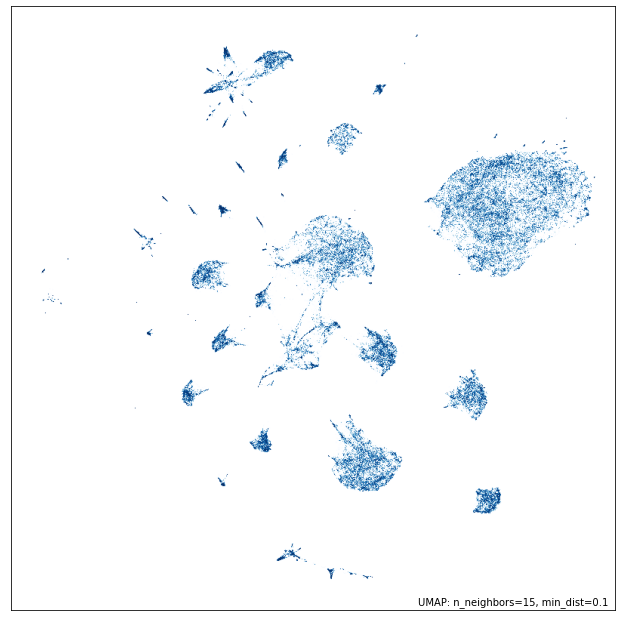

In [20]:
umap.plot.points(mapper)

In [21]:
mapper2 = umap.UMAP(densmap=True).fit(df3[np.random.choice(df3.shape[0], 10000, replace=False)])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

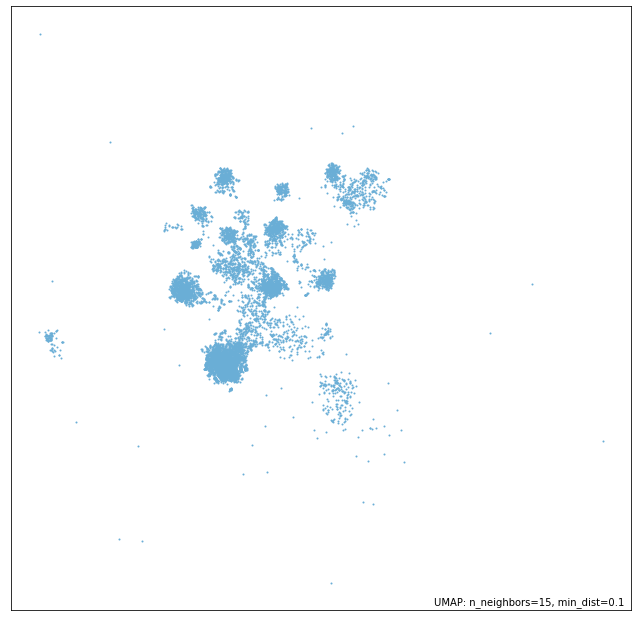

In [22]:
umap.plot.points(mapper2)

In [23]:
df3.data

In [24]:
df3.shape

(99441, 4154)

In [25]:
df3

array([[-0.24343309, -0.227793  , -0.00342352, ...,  0.        ,
         1.        ,  0.        ],
       [-0.24343309, -0.227793  ,  0.85408574, ...,  0.        ,
         1.        ,  0.        ],
       [-0.24343309, -0.227793  ,  0.07474101, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.24343309, -0.227793  , -0.46347009, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24343309, -0.227793  ,  2.9454442 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24343309, -0.227793  , -0.58377549, ...,  0.        ,
         1.        ,  0.        ]])

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


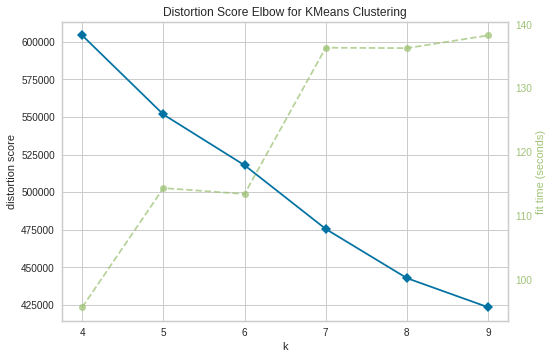

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(4,10), timings=True)
visualizer.fit(df3)
visualizer.show()

In [31]:
from sklearn.cluster import KMeans
X = df3
kmeans = KMeans(n_clusters=6, random_state=0, copy_x=False, precompute_distances=False).fit(X)

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:786: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "


In [32]:
kmeans.labels_

array([5, 5, 0, ..., 0, 5, 1], dtype=int32)

<AxesSubplot:>

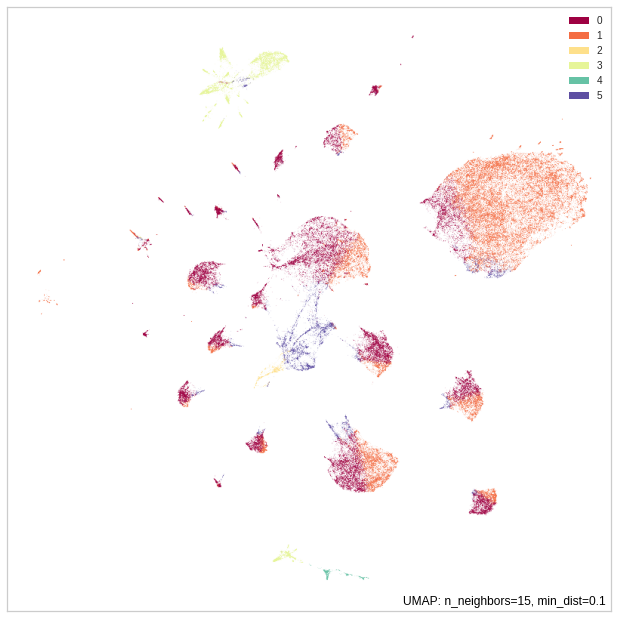

In [33]:
umap.plot.points(mapper, labels=kmeans.labels_)

In [35]:
df2

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,unique_orders_count,nof_moest_popular_sales,max_sale,median_sale,sum_sale,median_volume,average_delivery_time,average_expected_delivery_time
customer_id,,,,,,,,,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1.0,1.0,124.99,124.99,124.99,107136.0,761400.0,1673665.0
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1.0,1.0,289.00,289.00,289.00,53400.0,1439575.0,2085096.0
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1.0,1.0,139.94,139.94,139.94,45968.0,2253066.0,2101935.0
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1.0,1.0,149.94,149.94,149.94,79968.0,1295867.0,2361202.0
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1.0,1.0,230.00,230.00,230.00,23625.0,990258.0,1433310.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,1.0,1.0,74.90,74.90,74.90,11132.0,533900.0,1498303.0
e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,1.0,1.0,114.90,114.90,114.90,13200.0,642863.0,1352378.0
5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,1.0,1.0,37.00,37.00,37.00,9000.0,2674285.0,2000890.0


<AxesSubplot:>

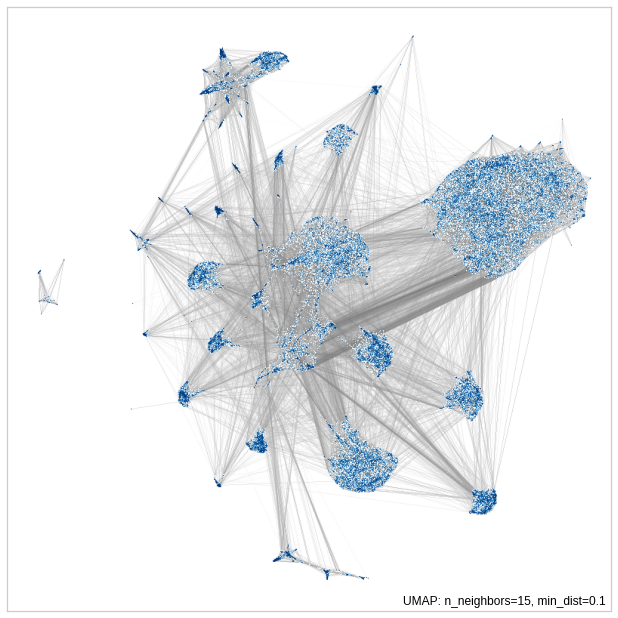

In [36]:
umap.plot.connectivity(mapper, show_points=True)

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/umap/plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

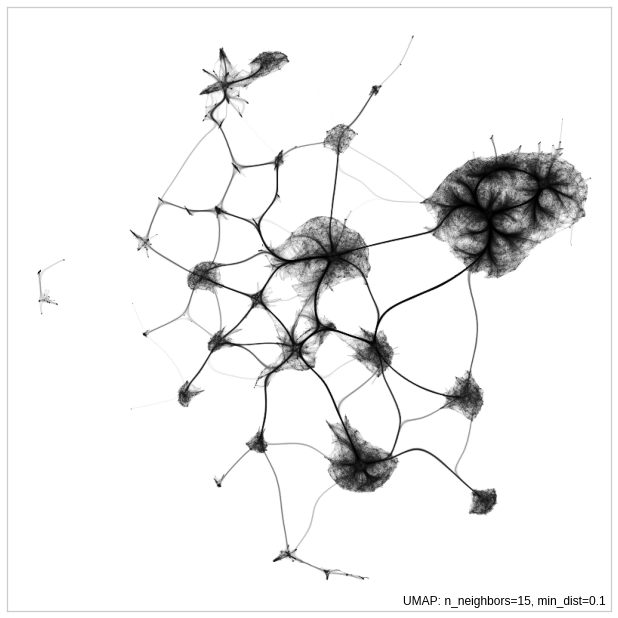

In [37]:
umap.plot.connectivity(mapper, edge_bundling='hammer')